## Set-up basic HurryWave model

### Modules and packages

Get hurrywave class for cht_hurrywave

In [1]:
import numpy as np
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import xarray as xr

from cht_hurrywave.hurrywave import HurryWave
from cht_hurrywave.bathymetry import HurryWaveBathymetry
from cht_bathymetry.database import BathymetryDatabase

c:\Users\asselt\AppData\Local\miniforge3\envs\cosmos\lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)



### Initialize model

In [2]:
model_path = r"c:\git\cht_hurrywave\examples\tmp"
hw = HurryWave(path=model_path)

### Domain and Grid

In [3]:
# Set domain input variables
specs = {'x0': -75, 'y0': 7, 'dx': 0.1, 'dy': 0.1, 
        'mmax': 200, 'nmax': 150, 'rotation': 0.0, 
        'crs_name': 'WGS 84', 'crs_type': 'geographic'}

hw.input.update(specs)
# Build grid
hw.grid.build()

hw.grid.exterior.to_file(os.path.join(hw.path, "gis", "region.geojson"), driver='GeoJSON')

### Bathymetry 


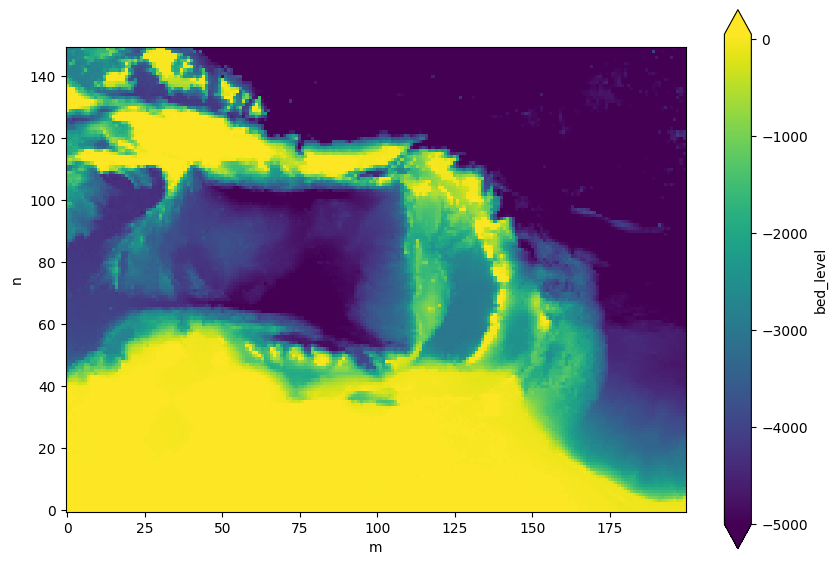

In [5]:
tif_file = r'c:\projects\2psips\Hurrywave\David_help\GEBCO_28_Jan_2025_4194e366587b\gebco_2024_n30.0_s0.0_w-80.0_e-40.0.tif'
data = rioxarray.open_rasterio(tif_file)
dep = data[0].data

# Interpolate to keep data small
x_dep = data.x
y_dep = data.y

xgr_dep, ygr_dep = np.meshgrid(x_dep, y_dep)

hw.input.update({'mskfile': 'hurrywave.msk', 'depfile': 'hurrywave.dep'})

# Get bathy/topo
bathymetry = HurryWaveBathymetry(hw = hw)
bathymetry.set_bathymetry_from_other_source2(hw.grid, xgr_dep[0,:], ygr_dep[:,0], dep, rectilinearSourceData=False)

da = xr.DataArray(
    data=bathymetry.z,
    coords=hw.grid.coordinates,
    dims=("n", "m"),
    attrs={"_FillValue": -99999.0},
)
hw.grid.ds["bed_level"] = da

fig, ax = plt.subplots(1,1, figsize = (10,7))
ax.set_aspect("equal")
hw.grid.ds["bed_level"].plot(ax = ax, vmin = -5000, vmax = 50)


### Mask

No name for obs file !


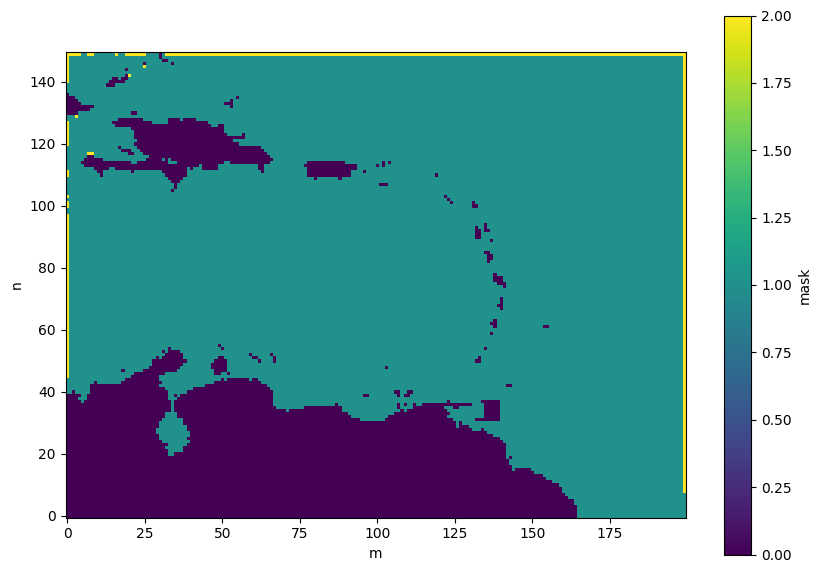

In [7]:
# Initialize polygons as None
include_polygon = None
exclude_polygon = None
boundary_polygon = None

boundary_polygon = gpd.read_file(os.path.join(hw.path, "gis", "open_boundary_polygon.shp"))
hw.grid.build_mask(zmin=-10000,
                    zmax=1,
                    include_polygon=include_polygon,
                    include_zmin=None, include_zmax=None,
                    boundary_polygon = boundary_polygon,
                    boundary_zmax= -2000
                    )

                    
hw.grid.write_msk_file()
fig, ax = plt.subplots(1,1, figsize = (10,7))
ax.set_aspect("equal")
hw.grid.ds.mask.plot(ax = ax)
hw.write()